# Cyclistic Full Year Analysis
### author: Gordon Lam
### date: 6/3/2023

This analysis is the case study 1 of the Google Data Analytics Certificate's capstone project. 
In this case study, I am using the Divvy dataset and use them to help answer the business task "How do annual members and casual riders use Cyclistic bikes differently?"

### Business Objectives
- What is our goal?
    - to maxmize the number of annual riders
- What is our problem?
    - __how annual members and casual riders diff from each other?__
    - why would casual riders buy annual membership?
    - how can Cyclistic use digital media to influence casual riders to become annual members?
- Who is our main stakeholders
    - Lily Moreno (our director of marketing and manager)
    - Cyclistic Executive Team (responsible for deciding whether to approve the recommended marketing program)
    
### Business Task
The marketing team at Cyclistic wants to design a new marketing strategy to convert casual riders into annual members by understanding how annual members and casual riders use Cyclistic bikes differently


### Data
The Divvy dataset is located in amazonaws and they are organized by date. The data is reliable and organized as it comes from the company. And it is also comprehensive, current and cited. 

The dataset is secured as the data are tokenized so that the personal information of the users can be protected.

However, the majority in the column "start_station_id", "start_station_name", "end_station_id", "end_station_name" of June, August, and December is null. Regarding the data integrity of these data, they are removed in the combined dataset. However, with the latitude and longitude of the start and end stations, we can locate back the corresponding start and end stations name and id if in real life situations.

### Process
- created a column called "ride_length" by substracting the "ended_at" by "started_at" column
- created a column called "day_of_week" representing the day of the week given the date

In [1]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import csv
import os
import glob
from pathlib import Path 

In [2]:
# paths
filepath = os.getcwd() + "/divvy-tripdata/"
csvpath = "csv/"
xlsxpath = "xlsx/"

In [3]:
def mergeCsv(filepath):
    df_list = []
    for file in glob.glob(filepath+csvpath+'*.csv'):
        df = pd.read_csv(file)
        df_list.append(df)
    combined_df = pd.concat(df_list)
    return combined_df

In [4]:
# merging all data
df = mergeCsv(filepath)

In [5]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,NaN,NaN,NaN,NaN,41.93,-87.69,41.94,-87.72,casual
1,DAD198F405F9C5F5,electric_bike,2022-08-08 14:39:21,2022-08-08 14:53:23,NaN,NaN,NaN,NaN,41.89,-87.64,41.92,-87.64,casual
2,E6F2BC47B65CB7FD,electric_bike,2022-08-08 15:29:50,2022-08-08 15:40:34,NaN,NaN,NaN,NaN,41.97,-87.69,41.97,-87.66,casual
3,F597830181C2E13C,electric_bike,2022-08-08 02:43:50,2022-08-08 02:58:53,NaN,NaN,NaN,NaN,41.94,-87.65,41.97,-87.69,casual
4,0CE689BB4E313E8D,electric_bike,2022-08-07 20:24:06,2022-08-07 20:29:58,NaN,NaN,NaN,NaN,41.85,-87.65,41.84,-87.66,casual


## Understand the variables

In [6]:
# Understand the variables
variables = pd.DataFrame(columns=['Variable', 'Number of Unique values', 'values'])

for i, var in enumerate(df.columns):
    variables.loc[i] = [var, df[var].nunique(), df[var].unique().tolist()]
    
variables

,Variable,Number of Unique values,values
0,ride_id,6203371,"[550CF7EFEAE0C618, DAD198F405F9C5F5, E6F2BC47B..."
1,rideable_type,3,"[electric_bike, classic_bike, docked_bike]"
2,started_at,5240059,"[2022-08-07 21:34:15, 2022-08-08 14:39:21, 202..."
3,ended_at,5253907,"[2022-08-07 21:41:46, 2022-08-08 14:53:23, 202..."
4,start_station_name,1703,"[nan, DuSable Museum, Robert Fulton Elementary..."
5,start_station_id,1319,"[nan, KA1503000075, 819, 13084, 15623, 13256, ..."
6,end_station_name,1725,"[nan, Western Ave & Roscoe St, Western Ave & 1..."
7,end_station_id,1324,"[nan, 15634, 691, TA1309000067, 15623, 13084, ..."
8,start_lat,727582,"[41.93, 41.89, 41.97, 41.94, 41.85, 41.79, 41...."
9,start_lng,687194,"[-87.69, -87.64, -87.65, -87.72, -87.63, -87.6..."


In [7]:
# Add day_of_week and ride_length column to the dataframe
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['day_of_week'] = df['started_at'].dt.dayofweek
df['weekday'] = df['started_at'].dt.day_name()
df['ride_length'] = df['ended_at'] - df['started_at']

In [8]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,day_of_week,weekday,ride_length
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,NaN,NaN,NaN,NaN,41.93,-87.69,41.94,-87.72,casual,6,Sunday,0 days 00:07:31
1,DAD198F405F9C5F5,electric_bike,2022-08-08 14:39:21,2022-08-08 14:53:23,NaN,NaN,NaN,NaN,41.89,-87.64,41.92,-87.64,casual,0,Monday,0 days 00:14:02
2,E6F2BC47B65CB7FD,electric_bike,2022-08-08 15:29:50,2022-08-08 15:40:34,NaN,NaN,NaN,NaN,41.97,-87.69,41.97,-87.66,casual,0,Monday,0 days 00:10:44
3,F597830181C2E13C,electric_bike,2022-08-08 02:43:50,2022-08-08 02:58:53,NaN,NaN,NaN,NaN,41.94,-87.65,41.97,-87.69,casual,0,Monday,0 days 00:15:03
4,0CE689BB4E313E8D,electric_bike,2022-08-07 20:24:06,2022-08-07 20:29:58,NaN,NaN,NaN,NaN,41.85,-87.65,41.84,-87.66,casual,6,Sunday,0 days 00:05:52


In [9]:
df['month'] = df['started_at'].dt.month

In [10]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,day_of_week,weekday,ride_length,month
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,NaN,NaN,NaN,NaN,41.93,-87.69,41.94,-87.72,casual,6,Sunday,0 days 00:07:31,8
1,DAD198F405F9C5F5,electric_bike,2022-08-08 14:39:21,2022-08-08 14:53:23,NaN,NaN,NaN,NaN,41.89,-87.64,41.92,-87.64,casual,0,Monday,0 days 00:14:02,8
2,E6F2BC47B65CB7FD,electric_bike,2022-08-08 15:29:50,2022-08-08 15:40:34,NaN,NaN,NaN,NaN,41.97,-87.69,41.97,-87.66,casual,0,Monday,0 days 00:10:44,8
3,F597830181C2E13C,electric_bike,2022-08-08 02:43:50,2022-08-08 02:58:53,NaN,NaN,NaN,NaN,41.94,-87.65,41.97,-87.69,casual,0,Monday,0 days 00:15:03,8
4,0CE689BB4E313E8D,electric_bike,2022-08-07 20:24:06,2022-08-07 20:29:58,NaN,NaN,NaN,NaN,41.85,-87.65,41.84,-87.66,casual,6,Sunday,0 days 00:05:52,8


In [11]:
# Define a function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

In [12]:
# Extract the month from the 'start_time' column and apply the 'get_season' function to create a new 'season' column
df['season'] = df['started_at'].dt.month.apply(get_season)

In [53]:
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

In [56]:
df['time_of_day'] = df['started_at'].dt.hour.apply(time_of_day)

In [57]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,day_of_week,weekday,ride_length,month,season,time_of_day
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,NaN,NaN,NaN,NaN,41.93,-87.69,41.94,-87.72,casual,6,Sunday,0 days 00:07:31,8,summer,Night
1,DAD198F405F9C5F5,electric_bike,2022-08-08 14:39:21,2022-08-08 14:53:23,NaN,NaN,NaN,NaN,41.89,-87.64,41.92,-87.64,casual,0,Monday,0 days 00:14:02,8,summer,Afternoon
2,E6F2BC47B65CB7FD,electric_bike,2022-08-08 15:29:50,2022-08-08 15:40:34,NaN,NaN,NaN,NaN,41.97,-87.69,41.97,-87.66,casual,0,Monday,0 days 00:10:44,8,summer,Afternoon
3,F597830181C2E13C,electric_bike,2022-08-08 02:43:50,2022-08-08 02:58:53,NaN,NaN,NaN,NaN,41.94,-87.65,41.97,-87.69,casual,0,Monday,0 days 00:15:03,8,summer,Night
4,0CE689BB4E313E8D,electric_bike,2022-08-07 20:24:06,2022-08-07 20:29:58,NaN,NaN,NaN,NaN,41.85,-87.65,41.84,-87.66,casual,6,Sunday,0 days 00:05:52,8,summer,Evening


Some features will not be relevant to our analysis as there are too many missing values (start_station_name, start_station_id, end_station_name, end_station_id). Plus there are features that we do not need (ride_id)

## Data Cleaning


In [58]:
# Check number of null values of each column
print(df.isnull().mean()*100)

ride_id                0.000000
rideable_type          0.000000
started_at             0.000000
ended_at               0.000000
start_station_name    14.587359
start_station_id      14.589487
end_station_name      15.601695
end_station_id        15.603968
start_lat              0.000000
start_lng              0.000000
end_lat                0.099913
end_lng                0.099913
member_casual          0.000000
day_of_week            0.000000
weekday                0.000000
ride_length            0.000000
month                  0.000000
season                 0.000000
time_of_day            0.000000
dtype: float64


We can see that they are 15% of the start_station_name, start_station_id, end_station_name and end_station_id missing. We will not try to remove these rows because there will be a huge data loss. As the start_lat, start_lng and end_lat, end_lng are present, we can use them to find the corresponding station. 
This may require more complicated works so I will analyse the location at last.

In [59]:
# Make a copy
df3 = df.copy()

In [60]:
# check if there are duplicated rides
df3.duplicated(subset=['ride_id']).sum()

0

Removing all rows where ride length was either under 1 minute or longer than 24 hours. As they might indicate unusual of ecceptional usage patterns that are not representative of the majority of users.

In [61]:
# Remove all the ride_length that is less than 1 minute
df3 = df3[(df3['ride_length'] > pd.Timedelta(minutes=1)) & (df3['ride_length'] < pd.Timedelta(hours=24))]


## Descriptive analysis 

In [62]:
# Total number of rides per user group
total_count = df3['member_casual'].value_counts()
total_count

member    3664295
casual    2391550
Name: member_casual, dtype: int64

In [63]:
total_count_df = pd.DataFrame({'member_casual': total_count.index, 'count': total_count.values})
total_count_df

,member_casual,count
0,member,3664295
1,casual,2391550


In [64]:
total_count_df.to_csv('./tableau_data/total_rides.csv')

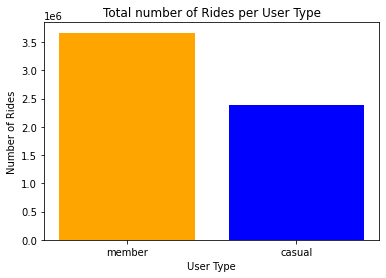

In [65]:
# Plot the total number of rides per user group
plt.bar(total_count.index, total_count.values, color=['orange', 'blue'])
plt.xlabel('User Type')
plt.ylabel('Number of Rides')
plt.title('Total number of Rides per User Type')
plt.show()

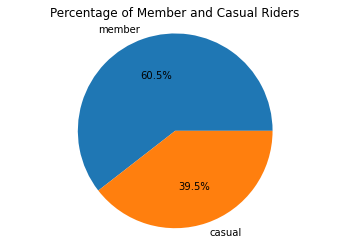

In [66]:
# Plot a pie chart to see the percentage
total_count_percentage = df3['member_casual'].value_counts(normalize=True)
plt.pie(total_count_percentage, labels=total_count_percentage.index, autopct='%1.1f%%')
plt.title('Percentage of Member and Casual Riders')
plt.axis('equal')
plt.show()

In [67]:
# Rideable type per user type
rideable_user_count = df.groupby(['rideable_type', 'member_casual'])['ride_id'].count()
rideable_user_count

rideable_type  member_casual
classic_bike   casual            933384
               member           1900028
docked_bike    casual            183466
electric_bike  casual           1331887
               member           1854606
Name: ride_id, dtype: int64

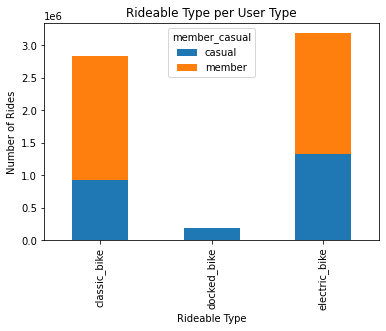

In [68]:
# Plot the rideable type per user type
rideable_user_count.unstack().plot(kind='bar', stacked=True)

plt.xlabel('Rideable Type')
plt.ylabel('Number of Rides')
plt.title('Rideable Type per User Type')
plt.show()

In [69]:
rideable_user_count_df = pd.DataFrame(rideable_user_count).reset_index()
rideable_user_count_df

,rideable_type,member_casual,ride_id
0,classic_bike,casual,933384
1,classic_bike,member,1900028
2,docked_bike,casual,183466
3,electric_bike,casual,1331887
4,electric_bike,member,1854606


In [70]:
rideable_user_count_df.to_csv('./tableau_data/rideable_user_count.csv')

Electric bikes were the most popular type of bicycles. Majority of the users used electric bike or classic bike. Docked bikes were used exclusively by casual riders. Marketing strategy on docked bikes will not be effective as members did not use docked bikes

In [71]:
# Descriptive analysis on ride_length (all figures in seconds)
df3['ride_length'].describe()

count                      6055845
mean     0 days 00:16:10.753855324
std      0 days 00:29:18.115223290
min                0 days 00:01:01
25%                0 days 00:05:54
50%                0 days 00:10:12
75%                0 days 00:18:11
max                0 days 23:59:56
Name: ride_length, dtype: object

In [72]:
# Compare members and casual users
print(df3.groupby('member_casual')['ride_length'].describe())

                 count                       mean                        std  \
member_casual                                                                  
casual         2391550  0 days 00:21:56.765459221  0 days 00:39:45.330509187   
member         3664295  0 days 00:12:24.924861944  0 days 00:18:45.020011360   

                           min              25%              50%  \
member_casual                                                      
casual         0 days 00:01:01  0 days 00:07:27  0 days 00:12:58   
member         0 days 00:01:01  0 days 00:05:12  0 days 00:08:49   

                           75%              max  
member_casual                                    
casual         0 days 00:23:53  0 days 23:59:56  
member         0 days 00:15:07  0 days 23:59:50  


In [144]:
# See the average ride time by each day for members vs casual users
avg_ride_length = df3.groupby(['member_casual', 'weekday'])['ride_length'].mean()
avg_ride_length = pd.DataFrame(avg_ride_length).reset_index()
# ride_length_formatted = avg_ride_length['ride_length'].apply(lambda x: "{:02d}:{:02d}:{:02d}".format(int(x.total_seconds() // 3600), int((x.total_seconds() % 3600) // 60), int(x.total_seconds() % 60)))
# avg_ride_length['ride_length'] = ride_length_formatted

In [145]:
avg_ride_length

,member_casual,weekday,ride_length
0,casual,Friday,0 days 00:20:36.254874432
1,casual,Monday,0 days 00:22:18.385026756
2,casual,Saturday,0 days 00:24:46.387619743
3,casual,Sunday,0 days 00:25:13.788949365
4,casual,Thursday,0 days 00:19:33.154460836
5,casual,Tuesday,0 days 00:19:34.246580622
6,casual,Wednesday,0 days 00:18:50.977400559
7,member,Friday,0 days 00:12:13.318689470
8,member,Monday,0 days 00:11:58.756340022
9,member,Saturday,0 days 00:13:54.131691844


In [146]:
avg_ride_length.to_csv('./tableau_data/avg_ride_length.csv', index=False)

In [74]:
# Find the number of rides by member type and weekday
rides_by_type_and_day = df3.groupby(['member_casual', 'weekday']).size().reset_index(name='count')

# Sort by count in descending order to get the day with the most rides for each type
max_rides_by_type_and_day = rides_by_type_and_day.sort_values(['member_casual', 'count'], ascending=[True, False]).groupby('member_casual').first()

# Print the day with the most rides for each type
print('Day with the most rides for members:', max_rides_by_type_and_day.loc['member', 'weekday'])
print('Day with the most rides for casual riders:', max_rides_by_type_and_day.loc['casual', 'weekday'])

Day with the most rides for members: Wednesday
Day with the most rides for casual riders: Saturday


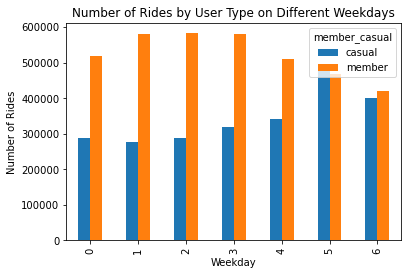

In [75]:
# Create a pivot table to count number of rides by user type and weekday
df_pivot = df3.pivot_table(index='day_of_week', columns='member_casual', values='ride_id', aggfunc='count')

# Plot the pivot table
ax = df_pivot.plot(kind='bar')
ax.set_xlabel('Weekday')
ax.set_ylabel('Number of Rides')
ax.set_title('Number of Rides by User Type on Different Weekdays')
plt.show()

In [76]:
rides_counts_day = pd.DataFrame(rides_by_type_and_day)
rides_counts_day

,member_casual,weekday,count
0,casual,Friday,342604
1,casual,Monday,287780
2,casual,Saturday,477793
3,casual,Sunday,400520
4,casual,Thursday,318113
5,casual,Tuesday,277609
6,casual,Wednesday,287131
7,member,Friday,509565
8,member,Monday,519872
9,member,Saturday,469452


In [77]:
rides_counts_day.to_csv('./tableau_data/rides_counts_by_day.csv')

In [78]:
ride_avg_count = df3.groupby(['weekday', 'member_casual'])['ride_id'].count()/52
ride_avg_count

weekday    member_casual
Friday     casual            6588.538462
           member            9799.326923
Monday     casual            5534.230769
           member            9997.538462
Saturday   casual            9188.326923
           member            9027.923077
Sunday     casual            7702.307692
           member            8094.307692
Thursday   casual            6117.557692
           member           11163.096154
Tuesday    casual            5338.634615
           member           11176.057692
Wednesday  casual            5521.750000
           member           11208.961538
Name: ride_id, dtype: float64

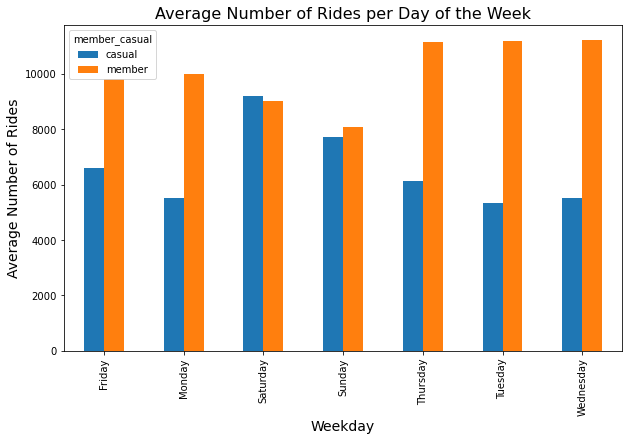

In [79]:
# create a bar plot
ax = ride_avg_count.unstack().plot(figsize=(10,6), kind='bar')

# set the title and axis labels
ax.set_title('Average Number of Rides per Day of the Week', fontsize=16)
ax.set_xlabel('Weekday', fontsize=14)
ax.set_ylabel('Average Number of Rides', fontsize=14)

# show the plot
plt.show()


In [80]:
ride_avg_count.to_csv('./tableau_data/ride_avg_count_by_day.csv')

In [81]:
# calculate the number of rides per season
df_grouped = df3.groupby(['season', 'member_casual'])['ride_id'].count()
df_grouped

season  member_casual
fall    casual            591815
        member            967995
spring  casual            546516
        member            966708
summer  casual           1108204
        member           1216602
winter  casual            145015
        member            512990
Name: ride_id, dtype: int64

In [82]:
rides_counts_by_season = pd.DataFrame(df_grouped).reset_index()
rides_counts_by_season

,season,member_casual,ride_id
0,fall,casual,591815
1,fall,member,967995
2,spring,casual,546516
3,spring,member,966708
4,summer,casual,1108204
5,summer,member,1216602
6,winter,casual,145015
7,winter,member,512990


In [83]:
rides_counts_by_season.to_csv('./tableau_data/ride_count_by_season.csv')

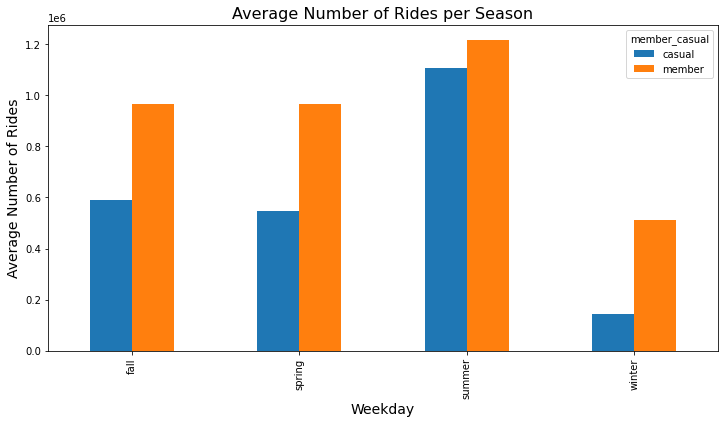

In [84]:
# create a bar plot
ax = df_grouped.unstack().plot(figsize=(12,6), kind='bar')

# set the title and axis labels
ax.set_title('Average Number of Rides per Season', fontsize=16)
ax.set_xlabel('Weekday', fontsize=14)
ax.set_ylabel('Average Number of Rides', fontsize=14)

# show the plot
plt.show()

In [85]:
# calculate the total number of rides per season and user type
df_grouped = df3.groupby(['season', 'member_casual'])['ride_id'].count()

# calculate the total number of rides per season
total_rides_per_season = df_grouped.groupby('season').sum()

# calculate the percentage of rides per season and user type
df_percentage = df_grouped.div(total_rides_per_season, level='season') * 100
df_percentage = df_percentage.unstack()

# display the percentage of rides per season and user type
print(df_percentage)


member_casual     casual     member
season                             
fall           37.941480  62.058520
spring         36.116001  63.883999
summer         47.668666  52.331334
winter         22.038586  77.961414


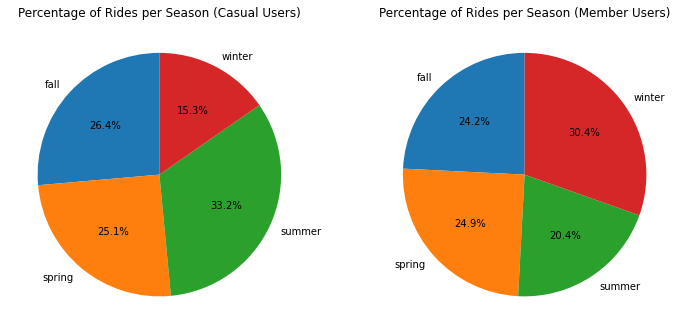

In [86]:
# create two subplots for each user type
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# plot the first pie chart for the casual user type
ax1.pie(df_percentage['casual'], labels=df_percentage.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Percentage of Rides per Season (Casual Users)')

# plot the second pie chart for the member user type
ax2.pie(df_percentage['member'], labels=df_percentage.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Percentage of Rides per Season (Member Users)')

# display the plot
plt.show()

In [87]:
# get the top 10 start locations by member type
top_10_start_locations = df3.groupby(['member_casual', 'start_lat', 'start_lng']).size().reset_index(name='count')
top_10_start_locations = top_10_start_locations.groupby('member_casual').apply(lambda x: x.nlargest(10, 'count')).reset_index(drop=True)
top_10_start_locations

,member_casual,start_lat,start_lng,count
0,casual,41.892278,-87.612043,41039
1,casual,41.880958,-87.616743,22708
2,casual,41.911722,-87.626804,16356
3,casual,41.926277,-87.630834,13144
4,casual,41.900960,-87.623777,12913
5,casual,41.881032,-87.624084,11441
6,casual,41.886976,-87.612813,9705
7,casual,41.867226,-87.615355,9504
8,casual,41.890000,-87.650000,9258
9,casual,41.912133,-87.634656,9016


In [88]:
# merge and find the matching start locations
top_10_start_locations = top_10_start_locations.merge(df3[['start_lat', 'start_lng', 'start_station_name', 'start_station_id']].drop_duplicates(), on=['start_lat', 'start_lng'], how='left')
top_10_start_locations

,member_casual,start_lat,start_lng,count,start_station_name,start_station_id
0,casual,41.892278,-87.612043,41039,Streeter Dr & Grand Ave,13022
1,casual,41.880958,-87.616743,22708,DuSable Lake Shore Dr & Monroe St,13300
2,casual,41.911722,-87.626804,16356,DuSable Lake Shore Dr & North Blvd,LF-005
3,casual,41.911722,-87.626804,16356,Streeter Dr & Grand Ave,13022
4,casual,41.911722,-87.626804,16356,State St & Van Buren St,TA1305000035
5,casual,41.926277,-87.630834,13144,Theater on the Lake,TA1308000001
6,casual,41.900960,-87.623777,12913,Michigan Ave & Oak St,13042
7,casual,41.881032,-87.624084,11441,Millennium Park,13008
8,casual,41.886976,-87.612813,9705,Dusable Harbor,KA1503000064
9,casual,41.867226,-87.615355,9504,Shedd Aquarium,15544


We can see that even with the same latitude and longitude, the name of the station can be different. The reason why this situation happens maybe happened due to rounding erros of differences in the precision of the coordinates. One way to address this is to use a small threshold distance for matching the latitude and longitude values.

In [89]:
df_grouped = df3.dropna()

In [90]:
# Making a new df with the distinct values of start station name to reduce the computation time
df_grouped = df_grouped.drop_duplicates(subset=['start_station_name'])
df_grouped

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,day_of_week,weekday,ride_length,month,season,time_of_day
142,241C440C74CB31BB,classic_bike,2022-08-05 16:13:36,2022-08-05 16:22:40,DuSable Museum,KA1503000075,Cottage Grove Ave & 51st St,TA1309000067,41.791568,-87.607852,41.803038,-87.606615,casual,4,Friday,0 days 00:09:04,8,summer,Afternoon
329,C34EE790A58C0434,classic_bike,2022-08-21 14:09:08,2022-08-21 15:10:46,California Ave & Division St,13256,California Ave & Division St,13256,41.903029,-87.697474,41.903029,-87.697474,casual,6,Sunday,0 days 01:01:38,8,summer,Afternoon
357,49259B4BA064D81B,electric_bike,2022-08-21 16:15:12,2022-08-21 16:29:30,Wood St & Chicago Ave,637,Wood St & Chicago Ave,637,41.895673,-87.672075,41.895634,-87.672069,casual,6,Sunday,0 days 00:14:18,8,summer,Afternoon
422,BEE91D557E47FE83,classic_bike,2022-08-21 02:11:26,2022-08-21 03:44:04,California Ave & Milwaukee Ave,13084,California Ave & Milwaukee Ave,13084,41.922695,-87.697153,41.922695,-87.697153,casual,6,Sunday,0 days 01:32:38,8,summer,Night
772,4479E16A664544D6,classic_bike,2022-08-16 15:50:44,2022-08-16 15:52:40,Campbell Ave & Montrose Ave,15623,Campbell Ave & Montrose Ave,15623,41.961526,-87.691165,41.961526,-87.691165,casual,1,Tuesday,0 days 00:01:56,8,summer,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43255,42BF2A960DA9BDB3,electric_bike,2023-01-14 12:14:56,2023-01-14 13:13:25,Public Rack - Avenue J & 102nd St,635,Public Rack - Baltimore Ave & 133rd St,581,41.710000,-87.530000,41.650000,-87.550000,member,5,Saturday,0 days 00:58:29,1,winter,Afternoon
107766,C0FA42A435828017,electric_bike,2023-01-23 12:22:56,2023-01-23 12:29:12,Public Rack - Talman Ave & 51st St,822,Public Rack - Western Blvd & 49th St,821,41.800000,-87.690000,41.800000,-87.680000,casual,0,Monday,0 days 00:06:16,1,winter,Afternoon
116874,A64015A6E371101A,electric_bike,2023-01-27 14:24:35,2023-01-27 14:36:13,Public Rack - Damen Ave & 80th St,715,Damen Ave & 59th St,561,41.750000,-87.670000,41.785861,-87.674144,casual,4,Friday,0 days 00:11:38,1,winter,Afternoon
142483,F5B7CC5601B7CB9E,electric_bike,2023-01-04 23:47:42,2023-01-04 23:51:33,Public Rack - Ewing Ave & 99th St,639,Public Rack - Ewing Ave & 105th St,613,41.720000,-87.540000,41.700000,-87.540000,casual,2,Wednesday,0 days 00:03:51,1,winter,Night


In [91]:
# Define a function to calculate the distance between two pairs of latitude and longitude values using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    a = np.sin(dLat / 2) * np.sin(dLat / 2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dLon / 2) * np.sin(dLon / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = R * c
    return d

# Define a threshold distance for matching the latitude and longitude values
threshold_distance_km = 0.1

# Get the top 10 start locations again
top_10_start_locations = df3.groupby(['member_casual', 'start_lat', 'start_lng']).size().reset_index(name='count')
top_10_start_locations = top_10_start_locations.groupby('member_casual').apply(lambda x: x.nlargest(10, 'count')).reset_index(drop=True)
# Merge the dataframes based on the threshold distance
top_10_start_locations = top_10_start_locations.merge(df_grouped[['start_lat', 'start_lng', 'start_station_name', 'start_station_id']].drop_duplicates(), on=['start_lat', 'start_lng'], how='left')

for i, row in top_10_start_locations.iterrows():
    # Calculate the distance between the current start location and all the start stations in the original dataframe
    distances = df_grouped.apply(lambda x: haversine(row['start_lat'], row['start_lng'], x['start_lat'], x['start_lng']), axis=1)
    
    # Find the closest start station within the threshold distance
    mask = distances <= threshold_distance_km
    if mask.any():
        top_10_start_locations.loc[i, 'start_station_name'] = df_grouped.loc[mask, 'start_station_name'].iloc[0]
        top_10_start_locations.loc[i, 'start_station_id'] = df_grouped.loc[mask, 'start_station_id'].iloc[0]


In [92]:
top_10_start_locations.drop_duplicates(inplace=True)

In [93]:
top_10_start_locations.to_csv('./tableau_data/top_10_start_locations.csv')

As there are still null values in start station name and start station id. I decided to visualize the data using start_lat and start_lng on a map

In [94]:

import folium

# Create a map centered on the average location of the top 10 start locations
avg_lat = top_10_start_locations['start_lat'].mean()
avg_lng = top_10_start_locations['start_lng'].mean()
map = folium.Map(location=[avg_lat, avg_lng], zoom_start=12)

# Add markers for the top 10 start locations with different colors based on the count
for i, row in top_10_start_locations.iterrows():
    count = row['count']
    location = [row['start_lat'], row['start_lng']]
    name = row['start_station_name']
    folium.Marker(location=location, popup=f'{name}: {count}',
                  icon=folium.Icon(color='red' if count > 20000 else 'blue' if count > 10000 else 'green')).add_to(map)

# Display the map
map

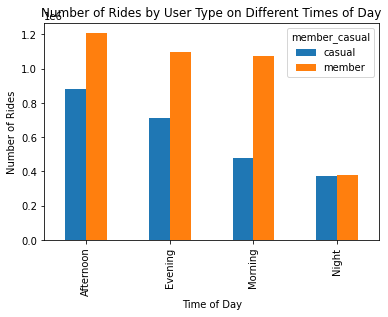

In [96]:
# Create a pivot table to count number of rides by user type and time of day
df_pivot = df.pivot_table(index='time_of_day', columns='member_casual', values='ride_id', aggfunc='count')

# Plot the pivot table
ax = df_pivot.plot(kind='bar')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Number of Rides')
ax.set_title('Number of Rides by User Type on Different Times of Day')
plt.show()

In [103]:
df_grouped = df3.groupby(['member_casual', 'time_of_day'])['ride_id'].count()
df_grouped = pd.DataFrame(df_grouped)
df_grouped = df_grouped.reset_index()

In [104]:
df_grouped.to_csv('./tableau_data/ride_count_by_time_of_day.csv')